# Lecture 5 exercises

In [42]:
!pip install devito > /dev/null 2>&1

## Excersie 1: Comparison against exact solution 1

An exact traveling wave solution to the 1-dimensional wave-equation,
$$\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}=0,$$
on the interval $x\in[0,1]$ with $c=1$ is given by:
$$u(x,t)=\left[\mathrm{max}(0,4\zeta(1-\zeta))\right]^{12},$$
where
$$\zeta=4(x-ct)-1,$$
subject to the boundary conditions $u(0,t)=u(1,t)=0$. Compose a Devito operator to solve this problem and check that the numerical solution returns to (approximately) the initial condition at $t=2$.

In [7]:
# required imports
import numpy as np
from devito import Grid, Function, TimeFunction, solve

# Python functions to compute the initial condition:
def compute_zeta(x,t):
    return 4.0*(x-t)-1.0

def compute_u(x,t):
    u1 = 4.0*compute_zeta(x,t)*(1.0-compute_zeta(x,t))
    u2 = np.zeros(u1.shape)
    return (np.maximum(u1,u2))**(12)

# define spatial mesh
# Size of rectangular domain
Lx = 1

# Number of grid points in each direction, including boundary nodes
Nx = 201

# hence the mesh spacing
dx = Lx/(Nx-1)

x = np.linspace(0,Lx,Nx)

grid = Grid(shape=(Nx), extent=(Lx))

# Initial condition
u_0 = Function(name='u_0', grid=grid)
u_0.data[:] = compute_u(x,0)

# We'll need one of these for composing the boundary conditions:
t = grid.stepping_dim
time = grid.time_dim

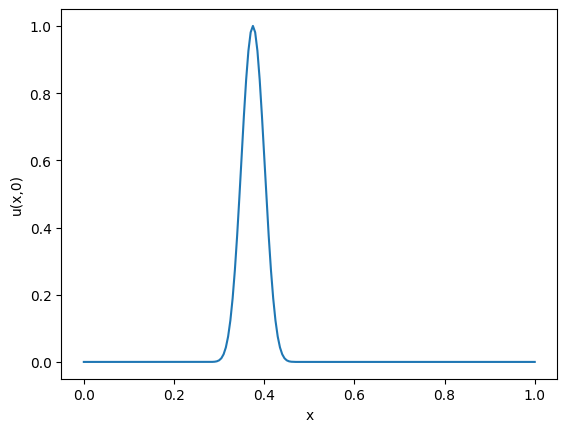

In [ ]:
# Plot the initial condition

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x, u_0.data[:])
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

In [ ]:
from devito import Grid, TimeFunction, Eq, Operator

In [ ]:
# Define our mesh

nx = 201  # Number of grid points in space
nt = 201  # Number of time steps
dx = 1.0 / (nx - 1)  # Spatial step size
dt = 0.001  # Time step size (small for stability)

grid = Grid(shape=(nx), extent=(1.0))  # 1D grid from x=0 to x=1

In [ ]:
# Define the wavefield
c = 1.
u = TimeFunction(name="u", grid=grid, time_order=2, space_order=4)

In [ ]:
# functions to compute the initial condition:
def compute_zeta(x,t):
    return 4.0*(x-t)-1.0

def compute_u(x,t):
    u1 = 4.0*compute_zeta(x,t)*(1.0-compute_zeta(x,t))
    u2 = np.zeros(u1.shape)
    return (np.maximum(u1,u2))**(12)

In [ ]:
# Define the equation
pde = (1/c**2) * (u.dt2-u.dx2) # wave eq

stencil = solve(pde, u.forward)
eq = Eq(u.forward, stencil) # This is our FD update scheme

In [ ]:
# Define IC

u_0 = Function(name='u_0', grid=grid)
u_0.data[:] = compute_u(x, 0)

In [ ]:
# Apply BCs & IC

bc = [Eq(u[t+1, 0], 0)]
bc += [Eq(u[t+1, nx-1], 0)]

# Set the initial conditions
u.data[0,:] = u_0.data[:]
u.data[1,:] = compute_u(x,dt)

In [ ]:
# Create the Devito operator and solve
op = Operator([eq]+bc)
op.apply(time_m=1, time_M=1999, dt=dt)

Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.00015999999999999966, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [ ]:
import matplotlib.pyplot as plt

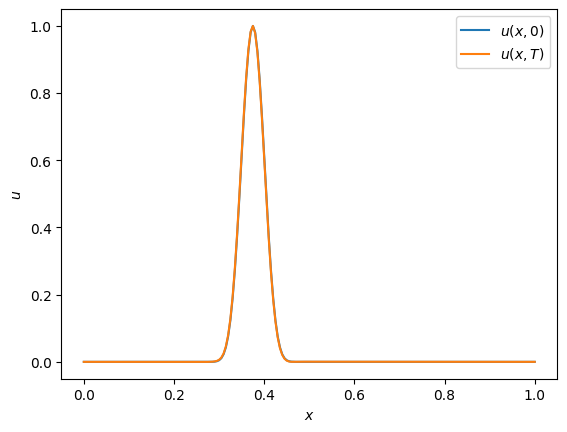

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x, u_0.data[:], label = "$u(x,0)$")
plt.plot(x, u.data[0, :], label = "$u(x,T)$")
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend()
plt.show()

Above, we see that the wave at $t=2$ is in the same state as in the IC. This is because the wave travels for 2 units of time without changing shape in a domain with an extent of 1 unit of size and reflecting boundary conditions.

#### **Hint** regarding boundary conditions:

Dirichlet boundary conditions can be set via a list of equation as, e.g., `bc=[Eq(u[t+1, 0], 0)]` and then included in an operator via `op=Operator([main_list_of_equations]+bc)`. See the linear convection example from the first notebook of lecture 10.

## Excersie 2: Comparison against exact solution 2

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="https://github.com/nocturnal-luke/Geophysical-inversion-undergraduate/blob/main/lectures/L5/figures/exact_solution.png?raw=1" width="450" height="450" align="center"/>

- **Show that the exact solution to this problem is:**
\begin{equation}
 u(x,t)=\sum_{n=1}^{\infty}A_{n}\sin\left(\frac{n\pi x}{10}\right)\cos\left(\frac{n\pi ct}{10}\right),
\end{equation}
where
\begin{equation}
  A_n=\frac{2}{n\pi}\left[\cos\left(\frac{4n\pi}{10}\right)-\cos\left(\frac{6n\pi}{10}\right)\right].
\end{equation}

Below is a snippet of code to plot the exact result at any point in time. You can use it to explore the evolution of the wave. Does it produce the expected behavior?

In [3]:
from numpy import sin, cos, pi, linspace, shape, zeros, mod

import matplotlib.pyplot as plt

# Global constants
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound

x = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Calculate exact solution

def u_e(x, t):
    s = zeros(x.size)
    for i in range(1,N+1):
        s+=A_n(i)*sin(i*pi*x/L)*cos(i*pi*c*t/L)
    return s

def A_n(n):
    const = 2/n/pi*(cos(4*n*pi/L)-cos(6*n*pi/L))
    return const

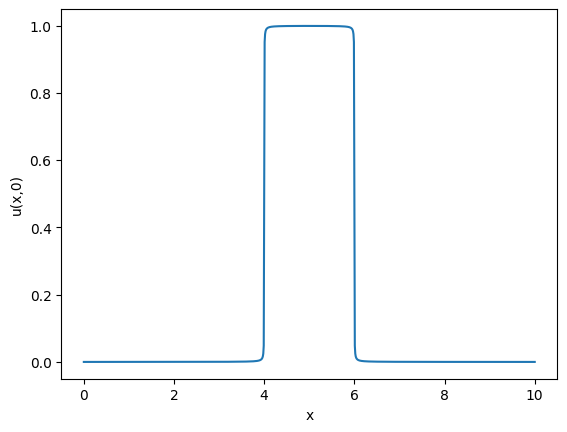

In [ ]:
%matplotlib inline
# Plot solution at a point T in time
T = 0
plt.plot(x, u_e(x, T))
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

- **Can you write a finite difference code to solve the above problem?**
- **Can you now also solve the same problem using Devito?**
- **How similar is your solution to the exact solution? How do you think this result can be improved?**

The  wave equation can be written as

$$u_{tt} = c^2 u_{xx}$$

and the 2nd temporal and spatial derivatives are

$$\frac{\partial^2 u}{\partial x^2} = \frac{u_{x+1}^t - 2u_x^{t} + u_{x -1}^{t}}{\Delta x^2},$$

and

$$\frac{\partial^2 u}{\partial t^2} = \frac{u_{x}^{t+1} - 2u_x^{t} + u_{x}^{t-1}}{\Delta t^2}.$$

Thus, we can fully discretise the 1D acoustic wave equation to form a time stepping scheme, i.e.,

$$u_x^{t+1} = c^2 \frac{\Delta t^2}{\Delta x^2}(u_{x+1}^t - 2u_x^{t} + u_{x -1}^{t}) + 2u^t_x - u^{t-1}_{x}.$$

For the purpose of a Python implementation I will write

$$u_x^{t+1} = c^2 \frac{\Delta t^2}{\Delta x^2}(\delta x) + \delta t,$$

where $\delta x = u_{x+1}^t - 2u_x^{t} + u_{x -1}^{t}$ and $\delta t = 2u^t_x - u^{t-1}_{x}.$

Let's implement this.

In [41]:
# First, defining our spatial mesh

x_extent = 10 # size of domain

nx = 1001 # number of mesh nodes
dx = x_extent / (nx - 1) # mesh spacing

nt = 2000 # number of time steps
dt = 0.004 # size of time steps

In [36]:
# Defining our wavefield
u = np.zeros((nx, nt))
c = 1.

Note now that our BCs are mixed and we must implement a finite difference stencil to specify the Neuman condition in our code. Note, this condition implies that the initial wavespeed is zero. Discretised, the Neuman condition reads

$$\frac{\partial u}{\partial t} \approx \frac{u_{x}^{t+1} - u^t_x}{\Delta t} = 0,$$

which we can rearrange to be

$$u_x^{t+1} = u_x^t .$$

This is simple to implement as below.

In [37]:
# Setting our ICs
u[400:600, 0] = 1 # Dirichlet portion
u[:, 1] = u[:, 0] # Neuman portion

Text(0.5, 1.0, '$u(x, 0)$')

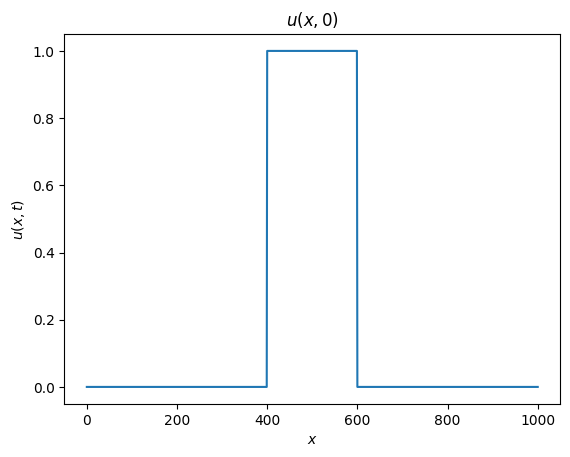

In [38]:
plt.plot(u[:,0])
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.title('$u(x, 0)$')

In [39]:
for T in range(1, nt - 1):
  for X in range(1, nx - 1):
    delta_x = u[X+1, T] - 2*u[X, T] + u[X-1, T] # T-1 for last T step
    delta_t = 2*u[X, T] - u[X, T-1]
    const = c**2 * (dt**2 / dx**2)

    u[X, T+1] = 2*u[X, T] - u[X, T-1] + (const * delta_x)

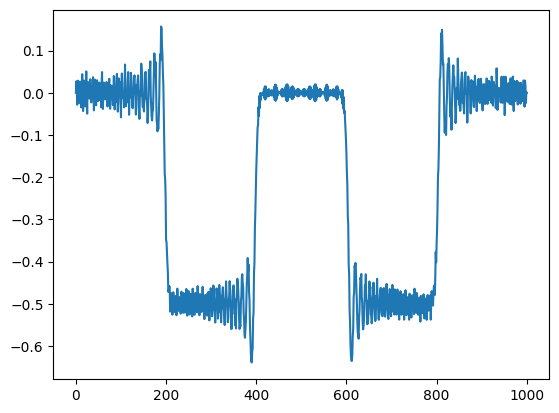

In [40]:
plt.plot(u[:,-1])

Right, now let's implement the same thing using Devito.

In [495]:
from devito import Grid, Eq, TimeFunction, Operator

In [509]:
# Define mesh parameters
nx = 1001 # number of nodes
nt = 2000 # number of time steps
x_extent = 10 # physical x extent

dx = x_extent / (dx-1) # mesh spacing
dt = 0.004 # time step

In [510]:
# Set up mesh
grid = Grid(shape=(nx), extent=(x_extent))

t = grid.stepping_dim # ensure BC applied at each time step from inside .apply

In [534]:
# Define our wavefield
c = 1.
u = TimeFunction(name="u", grid=grid, time_order=2, space_order=2)

In [529]:
# Define the equation
pde = (1/c**2) * (u.dt2-u.dx2) # wave eq

stencil = solve(pde, u.forward)
eq = Eq(u.forward, stencil) # This is our FD update scheme

In [530]:
# Define IC

u_0 = Function(name='u_0', grid=grid)
u_0.data[400:600] = 1

In [531]:
# Apply BCs and ICs

bc = [Eq(u[t + 1, 0], 0)]
bc += [Eq(u[t+1, -1], 0)]

# Set the ICs
u.data[0, :] = u_0.data[:]
u.data[1,:] = u.data[0, :]

In [532]:
# Generate the operator and apply
op = Operator([eq]+bc)
op.apply(time_m = 1, time_M = 4999, dt=dt)

Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0016059999999999649, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

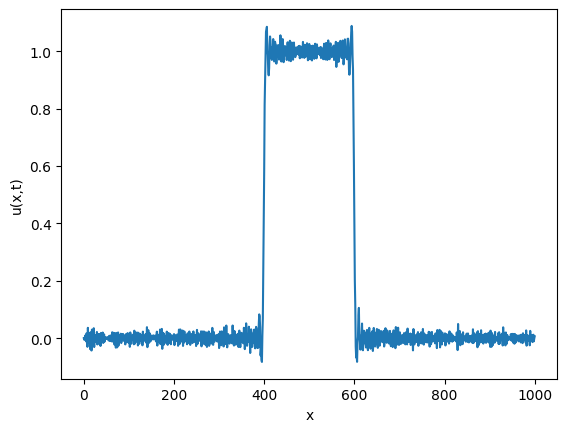

In [533]:
%matplotlib inline
# Lets plot some Devito results:
plt.plot(u.data[mod(5000,3), :])
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()

Above it is obvious that some numerical dispersion has occured. We can reduce this by improving our spatial order and grid/ time step resolution.

